In [1]:
from crowd_nav.configs.config import Config
import numpy as np

for i in range(10):
    #np.random.seed()
    config = Config()
    print(config.env.csl_workspace_type)

simple_corridor
simple_corridor
simple_corridor
simple_corridor
simple_corridor
simple_corridor
simple_corridor
simple_corridor
simple_corridor
simple_corridor


In [ ]:
import math
def world_to_robot_sim(px, py, x0, y0, cos_yaw, sin_yaw):
    # rotate the world coordinates (px, py) to the robot's local frame
    dx, dy = px - x0, py - y0
    forward  =  dx * cos_yaw + dy * sin_yaw
    lateral  = -dx * sin_yaw + dy * cos_yaw
    return forward, lateral

x0, y0 = 0, 1
cos, sin = math.cos(30), math.sin(30)
x_low, y_low = 1, -1
x_high, y_high = 3, 4
verts = [(x_low, y_low), (x_low, y_high),
        (x_high, y_low), (x_high, y_high)]


world_to_robot: (1.0, -1.0) -> (-2.48, -1.97)
world_to_robot: (3.0, -1.0) -> (-1.79, -3.85)
world_to_robot: (3.0, 4.0) -> (2.91, -2.14)
world_to_robot: (1.0, 4.0) -> (2.22, -0.26)
world_to_robot: (-4.0, -1.0) -> (-4.19, 2.73)
world_to_robot: (-2.0, -1.0) -> (-3.50, 0.85)
world_to_robot: (-2.0, 4.0) -> (1.20, 2.56)
world_to_robot: (-4.0, 4.0) -> (0.51, 4.44)
world_to_robot: (-1.0, 2.0) -> (-0.34, 0.94)
world_to_robot: (0.0, 3.0) -> (0.94, 0.34)
最窄通道宽度: 0.912 m @ forward s = 0.86 m
left_d = 0.160, right_d = 0.752


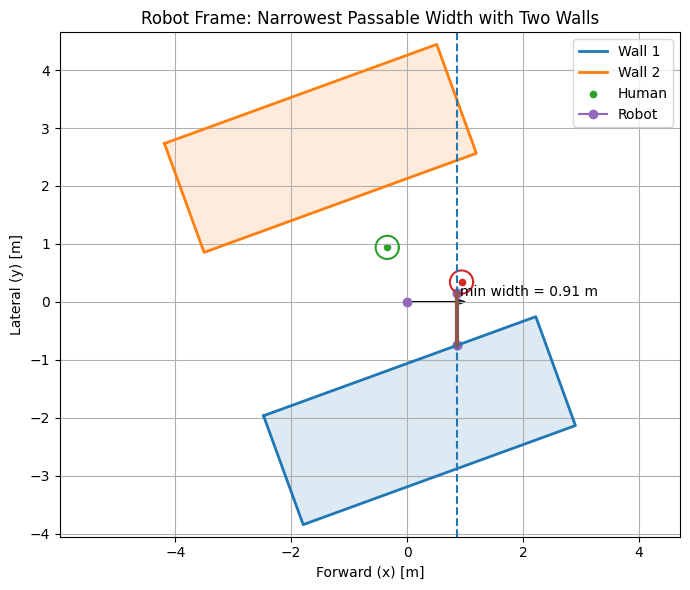

In [18]:
# -*- coding: utf-8 -*-
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List

# ---------- 坐标变换：世界 -> 机器人 ----------
def world_to_robot(px: float, py: float, x0: float, y0: float,
                   cos_yaw: float, sin_yaw: float) -> Tuple[float, float]:
    """
    把世界坐标点 (px, py) 转到以机器人为原点的机器人坐标系。
    forward = x轴（机器人前进方向），lateral = y轴（机器人左正右负）
    """
    dx, dy = px - x0, py - y0
    forward  =  dx * cos_yaw + dy * sin_yaw
    lateral  = -dx * sin_yaw + dy * cos_yaw
    print(f"world_to_robot: ({px}, {py}) -> ({forward:.2f}, {lateral:.2f})")
    return forward, lateral

def vertical_line_circle_interval(cx: float, cy: float, r: float, s: float):
    """
    竖直线 x=s 与圆 (cx,cy,r) 的交，返回 y 区间或 None
    """
    dx = s - cx
    if abs(dx) > r:
        return None
    dy = math.sqrt(max(0.0, r*r - dx*dx))
    return (cy - dy, cy + dy)

def vertical_line_polygon_intervals(poly: np.ndarray, s: float) -> List[Tuple[float, float]]:
    """
    竖直线 x=s 与凸/非凸多边形的交，返回该直线上的 y 区间列表（合并前）。
    对矩形一般只有 0 或 1 个区间。
    """
    ys = []
    n = len(poly)
    for i in range(n):
        x1, y1 = poly[i]
        x2, y2 = poly[(i + 1) % n]
        # 处理竖边
        if x1 == x2:
            if abs(s - x1) < 1e-9:  # 共线：整条边都在 x=s 上
                ys.extend([y1, y2])
            continue
        # 检查 [x1,x2] 是否跨过 s
        if (s - x1) * (s - x2) <= 0:
            t = (s - x1) / (x2 - x1)
            if 0.0 <= t <= 1.0:
                y = y1 + t * (y2 - y1)
                ys.append(y)

    ys.sort()
    # 将交点配对成区间（偶数个点为一组）
    intervals = []
    for i in range(0, len(ys), 2):
        if i + 1 < len(ys):
            intervals.append((ys[i], ys[i+1]))
    return intervals

def clearance_lr_at_s(s: float, blocking_intervals: List[Tuple[float, float]], cap: float):
    """
    给定 x=s 处的“阻塞区间”（y_low,y_high），计算
    左侧（y>0）可用距离 left_d，右侧（y<0）可用距离 right_d。
    cap 是上限（如果该侧没有障碍，就把距离截到 cap，便于绘图）。
    """
    # 若有区间覆盖 y=0，通道被挡住
    for y0, y1 in blocking_intervals:
        if y0 <= 0.0 <= y1:
            return 0.0, 0.0

    # 左侧：寻找最靠近 0 的正向边界（最小的 y_low>0）
    left_candidates = [y0 for (y0, y1) in blocking_intervals if y0 > 0]
    left_d = min(left_candidates) if left_candidates else cap

    # 右侧：寻找最靠近 0 的负向边界（最大的 y_high<0，距离为 |y_high|）
    right_candidates = [y1 for (y0, y1) in blocking_intervals if y1 < 0]
    right_d = abs(max(right_candidates)) if right_candidates else cap

    return left_d, right_d

def transform_points(points_world, x0, y0, yaw_deg):
    yaw = math.radians(yaw_deg)
    cos_yaw, sin_yaw = math.cos(yaw), math.sin(yaw)
    return np.array([world_to_robot(x, y, x0, y0, cos_yaw, sin_yaw) for x, y in points_world], dtype=float)

# ================== 输入 ==================
x0, y0 = 0.0, 2.0           # 机器人世界坐标
yaw_deg = 70.0              # 机器人朝向（度）

x_low,  y_low  = 1.0, -1.0  # 原墙左下
x_high, y_high = 3.0,  4.0  # 原墙右上

humans_world = [[-1.0, 2.0, 0.2], [0.0, 3.0, 0.2]]  # (x, y, 半径)

# 原墙（世界坐标）
wall1_world = np.array([
    (x_low,  y_low),
    (x_high, y_low),
    (x_high, y_high),
    (x_low,  y_high),
], dtype=float)

# 第二堵墙：在原墙基础上 x 坐标整体左移 3 米
wall2_world = wall1_world.copy()
wall2_world[:, 0] -= 5.0

# 障碍物：多个墙
walls_world = [wall1_world, wall2_world]

# =============== 变换到机器人坐标系 ===============
walls_robot = [transform_points(w, x0, y0, yaw_deg) for w in walls_world]
humans_robot = np.array(transform_points([(x, y) for x, y, _ in humans_world], x0, y0, yaw_deg))
human_rs = np.array([r for _, _, r in humans_world])

# =============== 扫描前向距离 ===============
S_MAX = 2.0
N_SAMPLES = 8
CAP = 5.0

s_vals = np.linspace(0.0, S_MAX, N_SAMPLES)
width_vals = []
lr_list = []

for s in s_vals:
    intervals = []

    # 每堵墙都加入竖线交的区间
    for poly in walls_robot:
        intervals.extend(vertical_line_polygon_intervals(poly, s))

    # 行人
    for (cx, cy), r in zip(humans_robot, human_rs):
        iv = vertical_line_circle_interval(cx, cy, r, s)
        if iv is not None:
            intervals.append(iv)

    # 合并重叠区间
    if intervals:
        intervals.sort()
        merged = [intervals[0]]
        for a, b in intervals[1:]:
            c, d = merged[-1]
            if a <= d + 1e-9:
                merged[-1] = (c, max(d, b))
            else:
                merged.append((a, b))
        intervals = merged

    left_d, right_d = clearance_lr_at_s(s, intervals, cap=CAP)
    lr_list.append((left_d, right_d, intervals))
    width_vals.append(left_d + right_d)

width_vals = np.array(width_vals)
idx = int(np.argmin(width_vals))
s_star = float(s_vals[idx])
left_star, right_star, intervals_star = lr_list[idx]
width_star = float(width_vals[idx])

print(f"最窄通道宽度: {width_star:.3f} m @ forward s = {s_star:.2f} m")
print(f"left_d = {left_star:.3f}, right_d = {right_star:.3f}")

# =============== 绘图（机器人坐标系） ===============
plt.figure(figsize=(7, 6))
# 画两堵墙
for i, poly in enumerate(walls_robot, start=1):
    rx = list(poly[:, 0]) + [poly[0, 0]]
    ry = list(poly[:, 1]) + [poly[0, 1]]
    plt.plot(rx, ry, linewidth=2, label=f"Wall {i}")
    plt.fill(rx, ry, alpha=0.15)

# 行人
theta = np.linspace(0, 2*np.pi, 100)
for (cx, cy), r in zip(humans_robot, human_rs):
    plt.plot(cx + r*np.cos(theta), cy + r*np.sin(theta))
    plt.scatter([cx], [cy], s=20, label="Human" if "Human" not in plt.gca().get_legend_handles_labels()[1] else None)

# 机器人与朝向
plt.plot(0, 0, marker="o", label="Robot")
plt.arrow(0, 0, 1.0, 0.0, length_includes_head=True, head_width=0.07)

# 最窄通道位置
plt.axvline(s_star, linestyle="--")
plt.plot([s_star, s_star], [-right_star, left_star], linewidth=3)
plt.scatter([s_star, s_star], [-right_star, left_star], s=40)
plt.text(s_star+0.05, 0.05, f"min width = {width_star:.2f} m", va="bottom")

plt.title("Robot Frame: Narrowest Passable Width with Two Walls")
plt.xlabel("Forward (x) [m]")
plt.ylabel("Lateral (y) [m]")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




In [6]:
from openai import OpenAI
import base64
import os
from dotenv import load_dotenv

load_dotenv("openai.env")
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

image_paths = ["test.png"]

# 将图片编码为 base64，用于上传
def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

def encode_image_from_bytes(image_bytes):
    return base64.b64encode(image_bytes).decode("utf-8")

image_payloads = [
    {
        "type": "image_url",
        "image_url": {
            "url": f"data:image/png;base64,{encode_image(path)}",
        }
    }
    for path in image_paths
]
'''
image_payloads = [
    {
        "type": "image_url",
        "image_url": {
            "url": f"data:image/png;base64,{encode_image_from_bytes(image_bytes)}"
        }
    }
]
'''

# 提示词
#prompt_text = "Suppose you are a wheeled robot performing social navigation tasks in a simulation environment. All green cylinders in the picture are humans. Please judge the current human activity and the robot's current environment based on the image I uploaded. Please select one output from ['walking', 'carrying', 'static', 'talking'] and ['simple_corner', 'simple_corridor'] respectively. Requirement: Only output the judgment content, do not output redundant content, and do not explain why. Output format: human_id, human activity, env, give all the info of detected human in this format"
prompt_text = "Suppose you are a wheeled robot performing social navigation tasks in a simulation environment. All green cylinders in the picture are humans. Please judge the current human activity and the robot's current environment based on the image I uploaded. Please select one output from ['walking', 'carrying', 'static', 'talking'] and ['simple_corner', 'simple_corridor'] respectively. Requirement: Only output the judgment content, no explain. Output format: 'human_id, human activity, env'. Give all the info of detected human in this format"
messages = [
    {"role": "user", "content": [*image_payloads, {"type": "text", "text": prompt_text}]}
]

response = client.chat.completions.create(
    model="gpt-4o-mini",  
    messages=messages,
    max_tokens=100,
    temperature=0.0, 
)



In [7]:
response.choices[0].message.content

'1, walking, simple_corridor'

In [8]:
# 分割
entries = [entry.strip() for entry in response.choices[0].message.content.split("\n") if entry.strip()]

human_id_list = []
activities = []
scene_type_list = []

for entry in entries:
    parts = entry.split(", ")
    if len(parts) == 3:
        human_id_list.append(parts[0])
        activities.append(parts[1])
        scene_type_list.append(parts[2])
print(entries)
print(human_id_list)
print(scene_type_list)
print(activities)

['1, walking, simple_corridor']
['1']
['simple_corridor']
['walking']
